# Data Cleaning for Our Dataset
### Evan Schubert
### CSC 2621-141
### Created on: 04/10/2025

What Each Column Represents
Transaction_ID - arbitrary unique ID given to each transaction<br>
User_ID - The unique identifier for each user<br>
Transaction Amount - amount of money transacted<br>
Transaction Type - ATM withdrawal, Bill Payment, POS payment, bank transfer, online purchase<br>
Time of Transaction - Military time for the time the transaction occured, 0 through 23<br>
Device Used - Tablet, mobile, desktop, unknown device<br>
Location - San Francisco, New York, Chicago, Boston, Houston, Miami, Los Angeles, Seattle<br>
Previous Fraudulent Transactions - How many previous fraudelent transactions does this user have, 0 through 4<br>
Account Age - How long the account has been active in possibly months, 0 through 119<br>
Number of Transactions last 24H - The number of transactions in the last 24 hours for this user, 1 through 14<br>
Payment Method - Debit card, credit card, UPI, net banking, invalid method<br>
Fraudulent - boolean representing whether the transaction was fraudulent.<br>

In [67]:
import pandas as pd
from scipy import stats
import numpy as np
from scipy.stats import stats, linregress, kruskal, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

fraud_df = pd.read_csv("Fraud Detection Dataset.csv")

In [93]:
## Calculate na percantages for each column
nan_counts = 100 * fraud_df.isna().sum() / len(fraud_df)
total_nan = fraud_df.isna().any(axis=1).sum()
print(nan_counts)
print(total_nan)
print(100 * total_nan / len(fraud_df))

Transaction_ID                      0.683707
User_ID                             0.683707
Transaction_Amount                  5.623599
Transaction_Type                    0.683707
Time_of_Transaction                 5.698309
Device_Used                         0.683707
Location                            0.683707
Previous_Fraudulent_Transactions    0.683707
Account_Age                         0.683707
Number_of_Transactions_Last_24H     0.683707
Payment_Method                      0.683707
Fraudulent                          0.683707
Transaction_Amount_fill_mean        0.683707
Transaction_Amount_fill_median      0.683707
Transaction_Amount_fill_mode        0.683707
Transaction_Amount_fill_KNN         4.751987
dtype: float64
4588
10.386905435693102


In [68]:
fraud_df.dropna(inplace = True, subset = ['Device_Used', 'Location', 'Payment_Method'])

In [69]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43869 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    43869 non-null  object 
 1   User_ID                           43869 non-null  int64  
 2   Transaction_Amount                41687 non-null  float64
 3   Transaction_Type                  43869 non-null  object 
 4   Time_of_Transaction               41654 non-null  float64
 5   Device_Used                       43869 non-null  object 
 6   Location                          43869 non-null  object 
 7   Previous_Fraudulent_Transactions  43869 non-null  int64  
 8   Account_Age                       43869 non-null  int64  
 9   Number_of_Transactions_Last_24H   43869 non-null  int64  
 10  Payment_Method                    43869 non-null  object 
 11  Fraudulent                        43869 non-null  int64  
dtypes: float6

In [70]:
fraud_df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0


In [71]:
print(fraud_df.columns)

Index(['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type',
       'Time_of_Transaction', 'Device_Used', 'Location',
       'Previous_Fraudulent_Transactions', 'Account_Age',
       'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent'],
      dtype='object')


In [72]:
fraud_df = fraud_df.astype({ 'Transaction_Type': 'category', 'Device_Used': 'category', 'Location': 'category','Payment_Method': 'category'})

## Filling in missing values

In [73]:
fraud_df["Transaction_Amount_fill_mean"] = fraud_df["Transaction_Amount"]
fraud_df["Transaction_Amount_fill_median"] = fraud_df["Transaction_Amount"]
fraud_df["Transaction_Amount_fill_mode"] = fraud_df["Transaction_Amount"]

values = {"Transaction_Amount_fill_mean": fraud_df["Transaction_Amount"].mean(), "Transaction_Amount_fill_median": fraud_df["Transaction_Amount"].median(), 
         "Transaction_Amount_fill_mode": stats.mode(fraud_df["Transaction_Amount"], nan_policy="omit").mode}
fraud_df.fillna(value = values, inplace = True)

C:\Users\cobbn\AppData\Local\Temp\ipykernel_13536\3331720827.py:6: DeprecationWarning: Please import `mode` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  "Transaction_Amount_fill_mode": stats.mode(fraud_df["Transaction_Amount"], nan_policy="omit").mode}


In [74]:
fraud_df.head(10)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0,1292.760000,1292.76,1292.76
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0,1554.580000,1554.58,1554.58
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0,100.100000,100.10,100.10
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0,1490.500000,1490.50,1490.50
5,T6,2095,2372.04,ATM Withdrawal,15.0,Desktop,Boston,3,96,14,Credit Card,0,2372.040000,2372.04,2372.04
6,T7,4772,544.81,Bill Payment,2.0,Tablet,Boston,3,6,9,UPI,1,544.810000,544.81,544.81
7,T8,4092,635.75,ATM Withdrawal,13.0,Tablet,Boston,2,13,10,Debit Card,0,635.750000,635.75,635.75
8,T9,2638,2318.87,Bank Transfer,NaN,Mobile,San Francisco,4,110,12,Debit Card,0,2318.870000,2318.87,2318.87
9,T10,3169,3656.17,Bill Payment,3.0,Mobile,Chicago,4,66,3,Net Banking,0,3656.170000,3656.17,3656.17
10,T11,1466,NaN,Online Purchase,3.0,Tablet,Houston,1,4,6,Net Banking,0,2993.984644,2522.53,49997.80


### Visualization

<Axes: xlabel='Transaction_Type', ylabel='Fraudulent'>

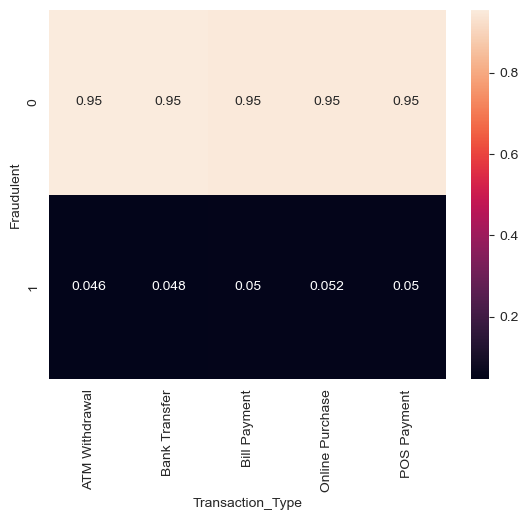

In [75]:
type_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Transaction_Type", aggfunc="count", observed=True)
type_table["ATM Withdrawal"] = type_table["ATM Withdrawal"]/(type_table["ATM Withdrawal"].sum())
type_table["Bank Transfer"] = type_table["Bank Transfer"]/(type_table["Bank Transfer"].sum())
type_table["Bill Payment"] = type_table["Bill Payment"]/(type_table["Bill Payment"].sum())
type_table["Online Purchase"] = type_table["Online Purchase"]/(type_table["Online Purchase"].sum())
type_table["POS Payment"] = type_table["POS Payment"]/(type_table["POS Payment"].sum())
sns.heatmap(type_table, annot=True)

<Axes: xlabel='Device_Used', ylabel='Fraudulent'>

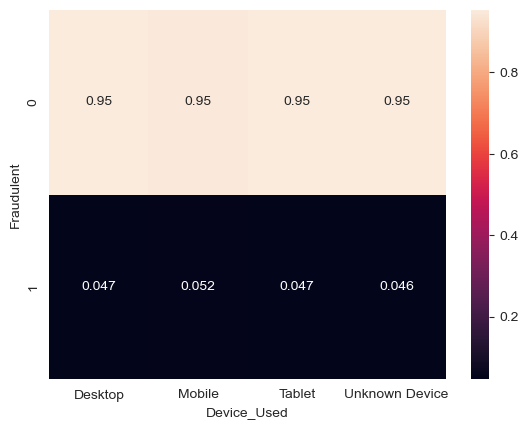

In [76]:
device_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Device_Used", aggfunc="count", observed=True)
for col in device_table.columns:
    device_table[col] = device_table[col]/device_table[col].sum()
sns.heatmap(device_table, annot=True)

<Axes: xlabel='Location', ylabel='Fraudulent'>

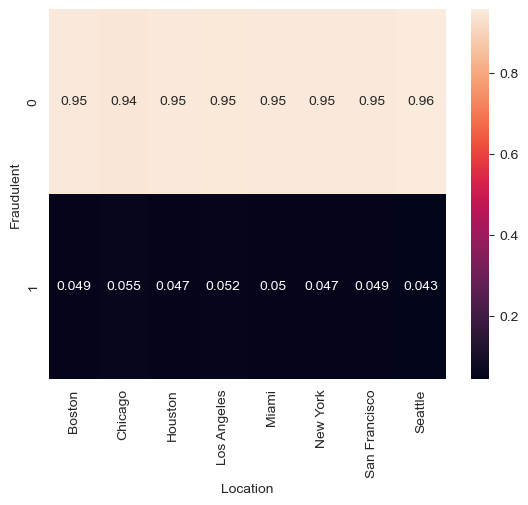

In [77]:
location_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Location", aggfunc="count", observed=True)
for col in location_table.columns:
    location_table[col] = location_table[col]/location_table[col].sum()
sns.heatmap(location_table, annot=True)

<Axes: xlabel='Payment_Method', ylabel='Fraudulent'>

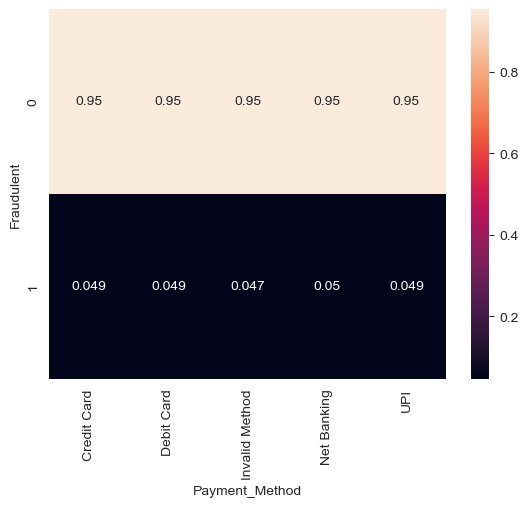

In [78]:
method_table = pd.pivot_table(fraud_df, index="Fraudulent", values="Transaction_ID", columns="Payment_Method", aggfunc="count", observed=False)
#type_table["ATM Withdrawal"] = type_table["ATM Withdrawal"]/(type_table["ATM Withdrawal"].sum())
for col in method_table.columns:
    method_table[col] = method_table[col]/method_table[col].sum()
sns.heatmap(method_table, annot=True)

Text(0.5, 1.0, 'Fraudulent Vs Transaction Amount')

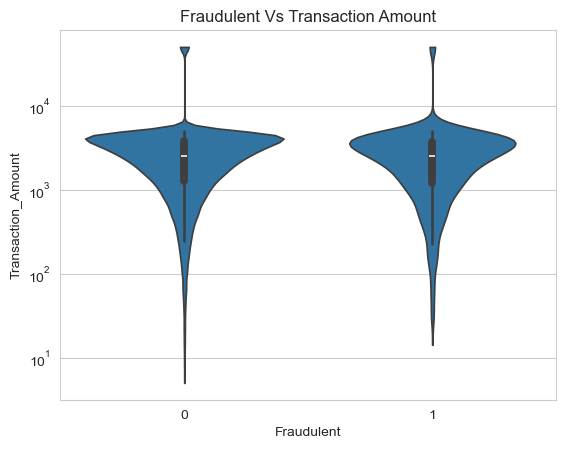

In [79]:
amount_plot = sns.violinplot(data=fraud_df, x="Fraudulent", y="Transaction_Amount",log_scale=True, cut=0)
amount_plot.set_title("Fraudulent Vs Transaction Amount")

### Statistical Testing

In [80]:
from pandas.core.dtypes.common import is_numeric_dtype

#Kruskal
#Transaction_Amount, Time_of_Transaction, Previous_Fraudulent_Transactions, Account_Age, Number_of_Transactions_Last_24H
#Chai Square
#Transaction_Type, Device_Used, Location, Payment_Method
X = ["Transaction_Amount", "Time_of_Transaction", "Previous_Fraudulent_Transactions", "Account_Age", "Number_of_Transactions_Last_24H", 
    "Transaction_Type", "Device_Used", "Location", "Payment_Method"]
var_name_above=[]
test_statistic_above=[]
p_values_above=[]
for col in X:
    if is_numeric_dtype(fraud_df[col]):
        samples_by_group = []
        for value in set(fraud_df["Fraudulent"]):
            mask_nulls = ~np.isnan(fraud_df[col])
            mask = fraud_df["Fraudulent"] == value
            samples_by_group.append(fraud_df[col][mask_nulls][mask])
        stat, p = kruskal(*samples_by_group)
        var_name_above.append(col)
        test_statistic_above.append(stat)
        p_values_above.append(p)
    else:
        combination_counts = pd.crosstab(fraud_df[col], fraud_df["Fraudulent"])
        chi2, p, _, _ = chi2_contingency(combination_counts)
        var_name_above.append(col)
        test_statistic_above.append(chi2)
        p_values_above.append(p)

## Calculate na percantages for each column

In [84]:
nan_counts = 100*fraud_df.isna().sum()/len(fraud_df)
nan_counts

Transaction_ID                      0.683707
User_ID                             0.683707
Transaction_Amount                  5.623599
Transaction_Type                    0.683707
Time_of_Transaction                 5.698309
Device_Used                         0.683707
Location                            0.683707
Previous_Fraudulent_Transactions    0.683707
Account_Age                         0.683707
Number_of_Transactions_Last_24H     0.683707
Payment_Method                      0.683707
Fraudulent                          0.683707
Transaction_Amount_fill_mean        0.683707
Transaction_Amount_fill_median      0.683707
Transaction_Amount_fill_mode        0.683707
Transaction_Amount_fill_KNN         4.751987
dtype: float64

Total nan count

In [92]:
total_nan = fraud_df.isna().any(axis=1).sum()
print(total_nan)
print(100*total_nan/len(fraud_df))

4588
10.386905435693102


## Bootstrap generator

In [115]:
import random
rows = []
for i in range(len(fraud_df)):
    if random.randint(0,1) == 0:
        rows.append(fraud_df[fraud_df["Fraudulent"] == 0].sample(n=1))
    else:
        rows.append(fraud_df[fraud_df["Fraudulent"] == 1].sample(n=1))
bootstrap_df = pd.concat(rows)
bootstrap_df
#todo ask if they should be balanced probabilistically like this or perfectly (exactly half and half)

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode,Transaction_Amount_fill_KNN
13331,T13332,1801.0,2645.82,Bill Payment,13.0,Desktop,New York,4.0,1.0,7.0,Credit Card,0.0,2645.820000,2645.82,2645.82,2941.324
42176,T42177,4752.0,2748.77,ATM Withdrawal,23.0,Mobile,Houston,0.0,109.0,5.0,Net Banking,0.0,2748.770000,2748.77,2748.77,2748.770
31848,T31849,3080.0,NaN,Online Purchase,14.0,Unknown Device,Houston,0.0,36.0,5.0,Net Banking,0.0,2993.984644,2522.53,49997.80,NaN
28844,T28845,1594.0,2249.36,Bill Payment,19.0,Desktop,Houston,1.0,113.0,10.0,Credit Card,0.0,2249.360000,2249.36,2249.36,2249.360
34376,T34377,3435.0,4065.53,POS Payment,7.0,Tablet,Chicago,4.0,69.0,3.0,Net Banking,0.0,4065.530000,4065.53,4065.53,3391.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16570,T16571,3036.0,3436.59,Bank Transfer,3.0,Mobile,Los Angeles,1.0,88.0,5.0,Credit Card,1.0,3436.590000,3436.59,3436.59,3436.590
46705,T46706,1757.0,4792.37,Bill Payment,1.0,Mobile,Houston,3.0,13.0,8.0,Credit Card,0.0,4792.370000,4792.37,4792.37,4792.370
18491,T18492,4092.0,4594.00,POS Payment,15.0,Mobile,Chicago,4.0,40.0,12.0,UPI,0.0,4594.000000,4594.00,4594.00,4594.000
19511,T19512,2446.0,786.15,Bill Payment,23.0,Tablet,Boston,1.0,97.0,13.0,Net Banking,0.0,786.150000,786.15,786.15,786.150


In [116]:
pd.concat(rows) 

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent,Transaction_Amount_fill_mean,Transaction_Amount_fill_median,Transaction_Amount_fill_mode,Transaction_Amount_fill_KNN
13331,T13332,1801.0,2645.82,Bill Payment,13.0,Desktop,New York,4.0,1.0,7.0,Credit Card,0.0,2645.820000,2645.82,2645.82,2941.324
42176,T42177,4752.0,2748.77,ATM Withdrawal,23.0,Mobile,Houston,0.0,109.0,5.0,Net Banking,0.0,2748.770000,2748.77,2748.77,2748.770
31848,T31849,3080.0,NaN,Online Purchase,14.0,Unknown Device,Houston,0.0,36.0,5.0,Net Banking,0.0,2993.984644,2522.53,49997.80,NaN
28844,T28845,1594.0,2249.36,Bill Payment,19.0,Desktop,Houston,1.0,113.0,10.0,Credit Card,0.0,2249.360000,2249.36,2249.36,2249.360
34376,T34377,3435.0,4065.53,POS Payment,7.0,Tablet,Chicago,4.0,69.0,3.0,Net Banking,0.0,4065.530000,4065.53,4065.53,3391.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16570,T16571,3036.0,3436.59,Bank Transfer,3.0,Mobile,Los Angeles,1.0,88.0,5.0,Credit Card,1.0,3436.590000,3436.59,3436.59,3436.590
46705,T46706,1757.0,4792.37,Bill Payment,1.0,Mobile,Houston,3.0,13.0,8.0,Credit Card,0.0,4792.370000,4792.37,4792.37,4792.370
18491,T18492,4092.0,4594.00,POS Payment,15.0,Mobile,Chicago,4.0,40.0,12.0,UPI,0.0,4594.000000,4594.00,4594.00,4594.000
19511,T19512,2446.0,786.15,Bill Payment,23.0,Tablet,Boston,1.0,97.0,13.0,Net Banking,0.0,786.150000,786.15,786.15,786.150
